In [65]:
!pip install torch
!pip install torchvision
import os
import sys
import time
import math
import torch.nn.init as init

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [66]:
!pip install torch-summary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


## Utility functions

In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Building the Model

### Basic ResNet 18 - Changing Planes - 4.6M parameters

In [68]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [69]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [70]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
device

'cuda'

## Data Processing

In [72]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [73]:

ROOT = '.data'
trainset = torchvision.datasets.CIFAR10(
    root=ROOT, train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=ROOT , train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2)
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples
print(n_train_examples)
print(n_valid_examples)
generator=torch.Generator().manual_seed(42)

train_data, valid_data = torch.utils.data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples], generator = generator)

Files already downloaded and verified
Files already downloaded and verified
45000
5000


In [74]:
import copy
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform_test

In [75]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 256, shuffle = True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 256, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 256, shuffle = False, num_workers=2)

In [76]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [77]:
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


==> Building model..


## Counting Parameters

In [78]:
print("Number of trainable parameters: ",count_parameters(net))

Number of trainable parameters:  4667850


In [79]:
net

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [80]:
lr = 0.001

In [81]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.SGD(net.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [82]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [83]:
def train(net, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    net.train()
    for (inputs, y) in iterator:
        inputs = inputs.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        
        y_pred = net(inputs)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [84]:
def evaluate(net, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    net.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Model 1 - 40 epochs, SGD optimizer, lr = 0.001

In [26]:
EPOCHS = 40
train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
  train_epoch_loss , train_epoch_acc = train(net, trainloader, optimizer, criterion, device)
  val_epoch_loss , val_epoch_acc = evaluate(net, validloader, criterion, device)

  print("Epoch", epoch)
  print("Train loss & accuracy", train_epoch_loss , train_epoch_acc)
  train_loss_history.append(train_epoch_loss)
  train_accuracies.append(train_epoch_acc)

  print("Validation loss & accuracy", val_epoch_loss , val_epoch_acc)
  val_loss_history.append(val_epoch_loss)
  val_accuracies.append(val_epoch_acc)

PATH = './saved_models/planes2_4.6M_sgd.pt'
torch.save(net, PATH)

Epoch 0
Train loss & accuracy 1.0656119585037231 0.6160768819126216
Validation loss & accuracy 1.0749781101942062 0.6272863060235977
Epoch 1
Train loss & accuracy 0.9809931848536838 0.6493723365393552
Validation loss & accuracy 0.9610892236232758 0.6454848349094391
Epoch 2
Train loss & accuracy 0.9094582704657858 0.6752112924375318
Validation loss & accuracy 0.8818873018026352 0.6898667275905609
Epoch 3
Train loss & accuracy 0.8495180816812948 0.6980406604707241
Validation loss & accuracy 0.9013927757740021 0.6931755512952804
Epoch 4
Train loss & accuracy 0.7938464666632089 0.7159570309926163
Validation loss & accuracy 0.7730545490980149 0.7306640625
Epoch 5
Train loss & accuracy 0.7486151595684615 0.7361123934388161
Validation loss & accuracy 0.7892149269580842 0.7177849262952805
Epoch 6
Train loss & accuracy 0.7055618105964228 0.7521812854842707
Validation loss & accuracy 0.7304593294858932 0.7432100176811218
Epoch 7
Train loss & accuracy 0.6665815355425532 0.7647505324672569
Validat

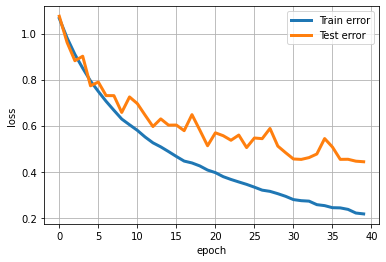

In [27]:
# loss curves
# lr = 0.001, SGD, 40 epochs, 64-64-256-256, no MaxPool, 4.6M parameters
plt.plot(range(40),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(40),val_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

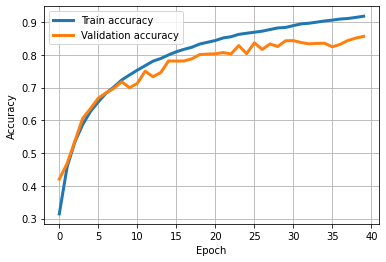

In [43]:
net = torch.load('./saved_models/planes2_4.6M_sgd.pt')

# accuracy curves
# lr = 0.001, SGD, 40 epochs, 64-64-256-256, no MaxPool,4.6M parameters

plt.plot(range(40), train_accuracies,'-', linewidth=3, label='Train accuracy')
plt.plot(range(40), val_accuracies,'-', linewidth=3, label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [44]:
test_loss_epoch, test_acc = evaluate(net, testloader,criterion, device)
print(test_loss_epoch)
print(test_acc)

0.4674379713833332
0.85517578125


## Model 2 - 40 epochs, Adam optimizer, lr = 0.001

In [39]:
EPOCHS = 40
train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []
for epoch in range(EPOCHS):
  train_epoch_loss , train_epoch_acc = train(net, trainloader, optimizer, criterion, device)
  val_epoch_loss , val_epoch_acc = evaluate(net, validloader, criterion, device)

  print("Epoch", epoch)
  print("Train loss & accuracy", train_epoch_loss , train_epoch_acc)
  train_loss_history.append(train_epoch_loss)
  train_accuracies.append(train_epoch_acc)

  print("Validation loss & accuracy", val_epoch_loss , val_epoch_acc)
  val_loss_history.append(val_epoch_loss)
  val_accuracies.append(val_epoch_acc)

PATH = './saved_models/planes2_4.6M_Adam40.pt'
torch.save(net, PATH)

Epoch 0
Train loss & accuracy 1.849104453894225 0.3142844458872622
Validation loss & accuracy 1.5718302607536316 0.42028952240943906
Epoch 1
Train loss & accuracy 1.4593033011664043 0.4575106533752246
Validation loss & accuracy 1.4673309743404388 0.46796875
Epoch 2
Train loss & accuracy 1.2784429429606958 0.5341974432495508
Validation loss & accuracy 1.282251787185669 0.5366613060235977
Epoch 3
Train loss & accuracy 1.1364775570956143 0.5871963778680022
Validation loss & accuracy 1.1022270798683167 0.606227022409439
Epoch 4
Train loss & accuracy 1.038836700672453 0.6270276988771829
Validation loss & accuracy 1.0200554013252259 0.6358226090669632
Epoch 5
Train loss & accuracy 0.9528310038149357 0.6565243252976374
Validation loss & accuracy 0.9353721261024475 0.6675666362047196
Epoch 6
Train loss & accuracy 0.8882439783350988 0.6829580966044556
Validation loss & accuracy 0.8987284272909164 0.6838579952716828
Epoch 7
Train loss & accuracy 0.8338449986820872 0.7017968747426163
Validation l

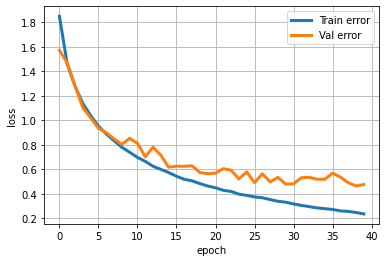

In [40]:
# lr = 0.001, Adam, 40 epochs, 64-64-256-256, no MaxPool, 4.6M parameters
plt.plot(range(40),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(40),val_loss_history,'-',linewidth=3,label='Val error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

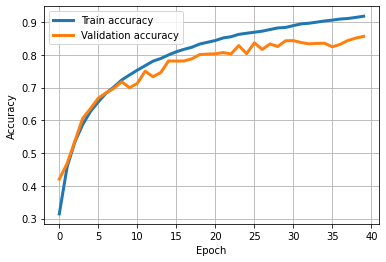

In [41]:
# lr = 0.001, Adam, 40 epochs, 64-64-256-256, no MaxPool, 4.6M parameters

plt.plot(range(40), train_accuracies,'-', linewidth=3, label='Train accuracy')
plt.plot(range(40), val_accuracies,'-', linewidth=3, label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [42]:
test_loss_epoch, test_acc = evaluate(net, testloader,criterion, device)
print(test_loss_epoch)
print(test_acc)

0.4901051126420498
0.84619140625


## Model 3 - 80 epochs, SGD optimizer, lr = 0.001

In [85]:
EPOCHS = 80
train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
  train_epoch_loss , train_epoch_acc = train(net, trainloader, optimizer, criterion, device)
  val_epoch_loss , val_epoch_acc = evaluate(net, validloader, criterion, device)

  print("Epoch", epoch)
  print("Train loss & accuracy", train_epoch_loss , train_epoch_acc)
  train_loss_history.append(train_epoch_loss)
  train_accuracies.append(train_epoch_acc)

  print("Validation loss & accuracy", val_epoch_loss , val_epoch_acc)
  val_loss_history.append(val_epoch_loss)
  val_accuracies.append(val_epoch_acc)

PATH = './saved_models/planes_4.6M_Adam_80epochs.pt'
torch.save(net, PATH)

Epoch 0
Train loss & accuracy 1.855218999765136 0.31381125697358087
Validation loss & accuracy 1.5963660776615143 0.4154181987047195
Epoch 1
Train loss & accuracy 1.4729001738808372 0.4570765270089561
Validation loss & accuracy 1.3631451070308684 0.5001608461141587
Epoch 2
Train loss & accuracy 1.2897527244958011 0.5290465199134566
Validation loss & accuracy 1.2515796542167663 0.5553079038858414
Epoch 3
Train loss & accuracy 1.1550702134316617 0.5836674361066385
Validation loss & accuracy 1.1738643229007721 0.5788717836141586
Epoch 4
Train loss & accuracy 1.0459233132952994 0.6246724074537103
Validation loss & accuracy 1.0403485983610152 0.6211856633424759
Epoch 5
Train loss & accuracy 0.958590853959322 0.6559534801000898
Validation loss & accuracy 1.1034198105335236 0.6129710465669632
Epoch 6
Train loss & accuracy 0.8867061453109438 0.6866796873509884
Validation loss & accuracy 0.9925831168889999 0.6486902564764023
Epoch 7
Train loss & accuracy 0.8270228224044497 0.7068510295992548
Va

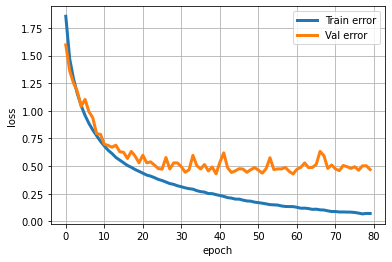

In [86]:
# lr = 0.001, sgd, 80 epochs, 64-64-256-256, no MaxPool, 4.6M parameters

net = torch.load('./saved_models/planes_4.6M_Adam_80epochs.pt')

plt.plot(range(80),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(80),val_loss_history,'-',linewidth=3,label='Val error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

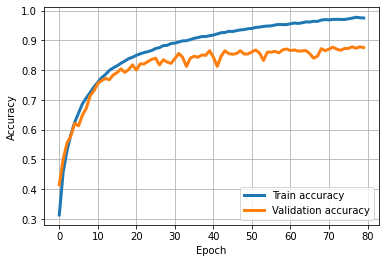

In [87]:
# lr = 0.001, sgd, 80 epochs, 64-64-256-256, no MaxPool, 4.6M parameters

plt.plot(range(80), train_accuracies,'-', linewidth=3, label='Train accuracy')
plt.plot(range(80), val_accuracies,'-', linewidth=3, label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [88]:
test_loss_epoch, test_acc = evaluate(net, testloader,criterion, device)
print(test_loss_epoch)
print(test_acc)

0.5084556207060814
0.8759765625
